In [3]:
import torch

In [6]:
torch.cuda.is_available()

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()

Dataloaders created
Model created
Train loop variables created
Epoch 0

starting epoch
Epoch [0/3], Step [0/3750],
train loss: 2.3034, train acc: 6.2500                             
validation loss: 2.2965, validation acc: 11.4700

Epoch [0/3], Step [10/3750],
train loss: 1.9093, train acc: 31.2500                             
validation loss: 2.1061, validation acc: 26.2500

Epoch [0/3], Step [20/3750],
train loss: 1.1652, train acc: 56.2500                             
validation loss: 1.8050, validation acc: 52.8800

Epoch [0/3], Step [30/3750],
train loss: 1.1933, train acc: 62.5000                             
validation loss: 1.6155, validation acc: 56.0600

Epoch [0/3], Step [40/3750],
train loss: 1.6159, train acc: 56.2500                             
validation loss: 1.5082, validation acc: 59.0200

Epoch [0/3], Step [50/3750],
train loss: 1.2041, train acc: 62.5000                             
validation loss: 1.4234, validation acc: 71.3400

Epoch [0/3], Step [60/3750],
trai

Epoch [1/3], Step [50/3750],
train loss: 0.2487, train acc: 93.7500                             
validation loss: 0.5728, validation acc: 89.4500

Epoch [1/3], Step [60/3750],
train loss: 0.2222, train acc: 87.5000                             
validation loss: 0.5699, validation acc: 88.4900

Epoch [1/3], Step [70/3750],
train loss: 0.1485, train acc: 100.0000                             
validation loss: 0.5674, validation acc: 84.4400

Epoch [1/3], Step [80/3750],
train loss: 1.2550, train acc: 75.0000                             
validation loss: 0.5652, validation acc: 88.8900

Epoch [1/3], Step [90/3750],
train loss: 0.6614, train acc: 81.2500                             
validation loss: 0.5626, validation acc: 89.0700

Epoch [1/3], Step [100/3750],
train loss: 0.6881, train acc: 81.2500                             
validation loss: 0.5599, validation acc: 89.3300

Epoch [1/3], Step [110/3750],
train loss: 0.1646, train acc: 100.0000                             
validation loss: 

Epoch [2/3], Step [110/3750],
train loss: 0.3834, train acc: 93.7500                             
validation loss: 0.4622, validation acc: 91.5700

Epoch [2/3], Step [120/3750],
train loss: 0.1316, train acc: 93.7500                             
validation loss: 0.4612, validation acc: 90.9500

Epoch [2/3], Step [130/3750],
train loss: 0.2670, train acc: 87.5000                             
validation loss: 0.4605, validation acc: 90.5700

Epoch [2/3], Step [140/3750],
train loss: 0.6625, train acc: 87.5000                             
validation loss: 0.4593, validation acc: 91.3700

Epoch [2/3], Step [150/3750],
train loss: 0.4595, train acc: 87.5000                             
validation loss: 0.4586, validation acc: 88.7800

Epoch [2/3], Step [160/3750],
train loss: 0.4291, train acc: 81.2500                             
validation loss: 0.4580, validation acc: 87.7800

Epoch [2/3], Step [170/3750],
train loss: 0.0575, train acc: 100.0000                             
validation lo

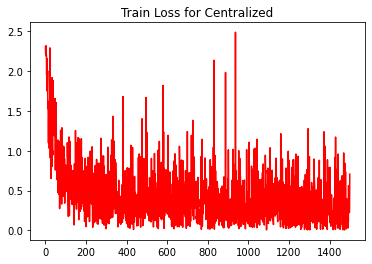

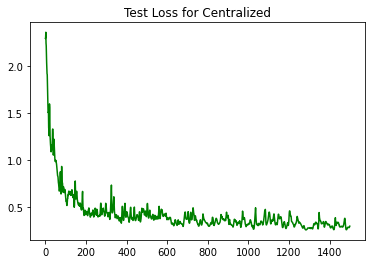

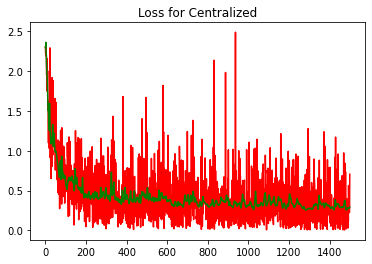

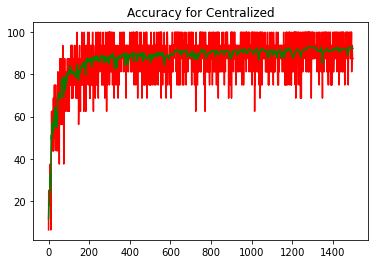

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd

class CustomMnistModel(nn.Module):

    def __init__(self, feature_size, num_classes) -> None:

        super(CustomMnistModel, self).__init__()

        self.fc1 = nn.Linear(feature_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, num_classes)
        # self.dropout = nn.Dropout(0.3)


    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

#from custom_dataset import CustomRNADatasetCentral
#from metrics import accuracy
#from fed_utils import return_scaled_weights, sum_scaled_weights, set_layer_weights

BATCH_SIZE = 16
NUM_WORKERS = 2
NUM_EPOCHS = 3
NUM_FEATURES = 28*28
NUM_CLASSES = 10
VALIDATION_SPLIT = 0.2
SHUFFLE_DATASET = True
RANDOM_SEED = 42
MPS_USED = True

##### Centralized Training Procedure #####

def main():

    # Setting the device to Apple Silicon
    if MPS_USED:
        device = torch.device("cuda")


    # Create dataset
    train_set = datasets.MNIST("", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
    valid_set = datasets.MNIST("", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

    # Create dataloaders
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)
    print("Dataloaders created")
    
    # Create model
    model = CustomMnistModel(NUM_FEATURES, NUM_CLASSES)
    if MPS_USED:
        model.to(device)
    print("Model created")
    # model.load_state_dict(torch.load('mnist_initial_model.pt'))

    criterion = nn.CrossEntropyLoss()
    total_steps = len(train_loader)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    valid_loss_min = np.Inf
    val_loss = []
    val_acc = []
    train_loss = []
    train_acc = []
    total_steps_taken = 0

    print("Train loop variables created")

    for epoch in range(NUM_EPOCHS):

        running_loss = 0.0
        epoch_steps_taken = 1
        # correct = 0
        # total = 0

        print(f'Epoch {epoch}\n')
        print("starting epoch")
        for batch_idx, (data_, target_) in enumerate(train_loader):

            correct = 0
            total = 0

            if batch_idx < 500:
                if MPS_USED:
                    data_ = data_.to(device)
                    target_ = target_.to(device)
                
                # print(data_.device)

                ### Fwd pass
                outputs = model(data_.view(-1, 28*28))

                ### Gradient calc
                loss = criterion(outputs, target_)
                loss.backward()
                optimizer.step()

                ### Print stats
                running_loss += loss.item()
                _, pred = torch.max(outputs, dim=1)
                correct += torch.sum(pred==target_).item()
                total += target_.size(0)
                
                
                # if total_steps_taken%5==0:
                #     scheduler.step()
                        
                train_acc.append(100*correct/total)
                train_loss.append(loss.item())
                # print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')


                ## Validate Model Accuracy

                batch_loss = 0
                total_t = 0
                correct_t = 0


                with torch.no_grad():
                    model.eval()
                    for data_t, target_t in (valid_loader):

                        ### To device
                        if MPS_USED:
                            data_t = data_t.to(device)
                            target_t = target_t.to(device)

                        ### Fwd pass
                        outputs_t = model(data_t.view(-1, 28*28))

                        ### Print Stats
                        loss_t = criterion(outputs_t, target_t)
                        batch_loss += loss_t.item()
                        _, pred_t = torch.max(outputs_t, dim=1)
                        correct_t += torch.sum(pred_t==target_t).item()
                        total_t += target_t.size(0)
                    
                    val_acc.append(100*correct_t/total_t)
                    val_loss.append(batch_loss/len(valid_loader))
                    network_learned = batch_loss < valid_loss_min
                    # print(f"validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n")

                    if network_learned:
                        valid_loss_min = batch_loss
                        torch.save(model.state_dict(), 'classification_model_mnist.pt')
                        # print('Saving current model due to improvement')

                    if (batch_idx % 10 == 0):
                        print(f'Epoch [{epoch}/{NUM_EPOCHS}], Step [{batch_idx}/{total_steps}],\ntrain loss: {train_loss[-1]:.4f}, train acc: {(100 * correct / total):.4f} \
                            \nvalidation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
                
                model.train()

                ### Zero gradients
                optimizer.zero_grad()
                epoch_steps_taken += 1
                total_steps_taken += 1
    
    train_loss_dict = pd.DataFrame({"loss":train_loss})
    train_acc_dict = pd.DataFrame({"loss":train_acc})
    val_loss_dict = pd.DataFrame({"loss":val_loss})
    val_acc_dict = pd.DataFrame({"loss":val_acc})

    train_acc_dict.to_csv("mnist_train_acc.csv")
    train_loss_dict.to_csv("mnist_train_loss.csv")
    val_acc_dict.to_csv("mnist_val_acc.csv")
    val_loss_dict.to_csv("mnist_val_loss.csv")
    
    plt.figure()
    plt.plot(np.array([x for x in range(len(train_loss))]), train_loss, color='r')
    plt.title("Train Loss for Centralized")
    # plt.ylim((0, 100))
    plt.savefig("mnist_centralized_loss_train.png")
    
    plt.figure()
    plt.plot(np.array([x for x in range(len(val_loss))]), val_loss, color='g')
    plt.title("Test Loss for Centralized")
    # plt.ylim((0, 100))
    plt.savefig("mnist_centralized_loss_test.png")
    
    plt.figure()
    plt.plot(np.array([x for x in range(len(train_loss))]), train_loss, color='r')
    plt.plot(np.array([x for x in range(len(val_loss))]), val_loss, color='g')
    plt.title("Loss for Centralized")
    # plt.ylim((0, 100))
    plt.savefig("mnist_centralized_loss.png")

    plt.figure()
    plt.plot(np.array([x for x in range(len(train_acc))]), train_acc, color='r')
    plt.plot(np.array([x for x in range(len(val_acc))]), val_acc, color='g')
    plt.title("Accuracy for Centralized")
    # plt.ylim((0, 100))
    plt.savefig("mnist_centralized_acc.png")

    



    

        
        
main()

            


                

                        
                    
                        
                    





    

    

    
